# Webscraping and beyond

**Ruthger Righart**

**Email**: rrighart@googlemail.com

**Website**: www.rrighart.com


Data is the new oil of the 21st century<font color="gray"><sup>1</sup></font>. Many data come from the web<font color="gray"><sup>2</sup></font>. Acquiring these webdata and structuring them is an essential skill that is called *webscraping*.

In this blog, I will briefly discuss how to webscrape data. However, it does not stop there. Analyses beyond webscraping are often needed. Some additional steps are shown, such as capturing hidden characters, merging different data, summary stats and visualization. Luckily, Python can be used for the whole analysis pipeline.

Healthdata are used for the current purpose, but it should be mentioned that many data can be webscraped in a similar way, sometimes with a few adaptations in the code.

**Important note**: Almost nothing is more dynamic than webdata. Please report me if code is not working, this may be due to changes in the downloaded webdata tables.

The current blog has been updated at **21-9-2018**. A previous version was published June 2017 at https://rrighart.github.io/ . The code is based on **Python 2.7**. Some minor changes may be needed for Python 3.4 and later versions.

In [1]:
import warnings
warnings.filterwarnings("ignore")

## **Healthcare rankings for different European countries** 

**Beautiful Soup** is a Python package that is used for webscraping<font color="gray"><sup>3</sup></font>. 
In this blog we are going to scrape tables from webpages.

In [2]:
import numpy as np
import pandas as pd
from bs4 import BeautifulSoup
import requests
import csv
import re
import urllib2
from datetime import datetime
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

First, you need to determine the directory where you save your data.  

We are going to scrape data from wikipedia<font color="gray"><sup>4</sup></font>. The data indicate rankings on different health indices, such as patient rights and information, accessibility (waiting time for treatment), outcomes, range and reach of services provided, prevention, and pharmaceuticals. The data are from the Euro Health Consumer index. In the following code, we read the data and use BeautifulSoup to convert the data in so-called **bs4.BeautifulSoup** data. Several data visualizations using Tableau can be found on my blog page<font color="gray"><sup>5</sup></font>.

In [3]:
url = 'https://en.wikipedia.org/wiki/Healthcare_in_Europe' 
r = requests.get(url)
HCE = BeautifulSoup(r.content)
type(HCE)

bs4.BeautifulSoup

We could display the data using <font color="blue">print(HCE.prettify())</font>. We will not do that here because it will produce a great amount of text (or soup).

We first need to select the table that we'd like to scrape. As many webpages contain multiple tables, it would be good to read from the HTML the specific tablenames into a list, that we will call <font color="red">lst</font><font color="gray"><sup>6</sup></font>:

In [4]:
htmlpage = urllib2.urlopen(url)
lst = []
for line in htmlpage:
    line = line.rstrip()
    if re.search('table class', line) :
        lst.append(line)

This list <font color="red">lst</font> has a length of 3:

In [5]:
len(lst)

3

Now let us display <font color="red">lst</font>:

In [6]:
lst

['<table class="wikitable sortable">',
 '<table class="wikitable sortable">',
 '<div role="navigation" class="navbox" aria-labelledby="Healthcare_in_Europe" style="padding:3px"><table class="nowraplinks collapsible autocollapse navbox-inner" style="border-spacing:0;background:transparent;color:inherit"><tbody><tr><th scope="col" class="navbox-title" colspan="2"><div class="plainlinks hlist navbar mini"><ul><li class="nv-view"><a href="/wiki/Template:Healthcare_in_Europe" title="Template:Healthcare in Europe"><abbr title="View this template" style=";;background:none transparent;border:none;-moz-box-shadow:none;-webkit-box-shadow:none;box-shadow:none; padding:0;">v</abbr></a></li><li class="nv-talk"><a href="/wiki/Template_talk:Healthcare_in_Europe" title="Template talk:Healthcare in Europe"><abbr title="Discuss this template" style=";;background:none transparent;border:none;-moz-box-shadow:none;-webkit-box-shadow:none;box-shadow:none; padding:0;">t</abbr></a></li><li class="nv-edit"><a 

We will scrape the first table, and therefore use index 0 in <font color="red">lst</font> to capture the first table name. Now it is about time to read in the table using Beautiful Soup's <font color="blue">find</font> function. A simple option is to type in the table name. You simply select the name in <font color="red">lst</font>, which in this case is "wikitable sortable":

In [7]:
table=HCE.find('table', {'class', 'wikitable sortable'})

Alternatively, there is a way to automate this step, by capturing the first data from the list, and then stripping off the unneeded characters.

In [8]:
x=lst[0]
extr=re.findall('"([^"]*)"', x)
table=HCE.find('table', {'class', str(extr).strip("'[]'")})

In [9]:
type(table)

bs4.element.Tag

Now it would be good to read in separately the header and row names, so we later can easily make a DataFrame.

In [10]:
headers= [header.text for header in table.find_all('th')]

In [11]:
headers

[u'Country\n',
 u'Ranking\n',
 u'Total Score\n',
 u'Patient rights & Information\n',
 u'Accessibility (waiting times)\n',
 u'Outcomes\n',
 u'Range and reach of services provided\n',
 u'Prevention\n',
 u'Pharmaceuticals\n']

In [12]:
rows = []
for row in table.find_all('tr'):
    rows.append([val.text.encode('utf8') for val in row.find_all('td')])

Now all elements, -- rows and headers --, are available to build the DataFrame, which we will call <font color="red">df1</font>. 

In [13]:
df1 = pd.DataFrame(rows, columns=headers)

In [14]:
df1.head(7)

,Country,Ranking,Total Score,Patient rights & Information,Accessibility (waiting times),Outcomes,Range and reach of services provided,Prevention,Pharmaceuticals
0,None,None,None,None,None,None,None,None,None
1,Netherlands\n,1\n,924\n,125\n,200\n,278\n,125\n,107\n,89\n
2,Switzerland\n,2\n,898\n,117\n,225\n,278\n,94\n,101\n,83\n
3,Denmark\n,3\n,864\n,117\n,118\n,267\n,120\n,95\n,119\n
4,Norway\n,4\n,850\n,125\n,125\n,289\n,115\n,119\n,78\n
5,Luxembourg\n,5\n,850\n,104\n,213\n,244\n,109\n,107\n,72\n
6,Finland\n,6\n,856\n,108\n,150\n,289\n,120\n,101\n,78\n


This table still needs a good amount of preprocessing, on which we will return later.

## **Health Expenditure**

Of course, other data sources can be scraped as well. So let us load data about health expenditure<font color="gray"><sup>7</sup></font>. These are data per capita, which means that expenditure was corrected for the number of habitants in a country. Saving time, we will now put the script in one code block. This should lead to a DataFrame <font color="red">df2</font>:

In [15]:
url = 'https://en.wikipedia.org/wiki/List_of_countries_by_total_health_expenditure_per_capita' 
r = requests.get(url)
HEE = BeautifulSoup(r.content)
htmlpage = urllib2.urlopen(url)
lst = []
for line in htmlpage:
    line = line.rstrip()
    if re.search('table class', line) :
        lst.append(line)
x=lst[1]
print x
extr=re.findall('"([^"]*)"', x)
table=HEE.find('table', {'class', 'wikitable sortable'})
headers= [header.text for header in table.find_all('th')]
rows = []
for row in table.find_all('tr'):
    rows.append([val.text.encode('utf8') for val in row.find_all('td')])
headers = [i.replace("\n", "") for i in headers]
df2 = pd.DataFrame(rows, columns=headers)

<table class="wikitable">


In [16]:
df2.head()

,Country,2013,2014,2015,2016
0,None,None,None,None,None
1,Australia,"4,186","4,289","4,493","4,708\n"
2,Austria,"4,861","5,001","5,100","5,227\n"
3,Belgium,"4,505","4,656","4,778","4,840\n"
4,Canada,"4,461","4,502","4,613","4,753\n"



## **Additional preprocessing steps**

If we look at the dataframes, we see that there are still some issues that prohibit numeric computations. There are undesired characters ('\n'), undesired decimal format (comma should be removed), there are cells with non-numeric characters ('x') that should be NAN, and several columns should be numeric instead of objects. To resolve this, we will write a preprocessing function called **preproc**, which accepts as input any DataFrame (in our case df1 and df2). Please note that each webtable may need its unique collection of preprocessing steps.  

In [17]:
def preproc(dat):
    dat.dropna(axis=0, how='all', inplace=True)
    dat.columns = dat.columns.str.replace("\n", "")    
    dat.replace(["\n"], [""], regex=True, inplace=True)
    dat.replace([","], [""], regex=True, inplace=True)
    dat.replace(r"\b[a-zA-Z]\b", np.nan, regex=True, inplace=True)
    dat = dat.apply(pd.to_numeric, errors='ignore')    
    return(dat)

In [18]:
df1 = preproc(df1)
df2 = preproc(df2)

Apparently, after this preprocessing there are some NANs:

In [19]:
print(df1.isnull().sum().sum())
print(df2.isnull().sum().sum())

8
0


Now we display where the NANs occur. In fact, when we check the original table, we can see that Cyprus has values "x", which were in our preproc function changed to NANs ( https://en.wikipedia.org/wiki/Healthcare_in_Europe )

In [20]:
df1[df1.isnull().any(axis=1)]

,Country,Ranking,Total Score,Patient rights & Information,Accessibility (waiting times),Outcomes,Range and reach of services provided,Prevention,Pharmaceuticals
35,Cyprus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Now we remove the NANs:

In [21]:
df1.dropna(axis=0, how='any', inplace=True)

At this point we inspect the data types:

In [22]:
df1.dtypes

Country                                  object
Ranking                                 float64
Total Score                             float64
Patient rights & Information            float64
Accessibility (waiting times)           float64
Outcomes                                float64
Range and reach of services provided    float64
Prevention                              float64
Pharmaceuticals                         float64
dtype: object

In [23]:
df2.dtypes

Country    object
2013        int64
2014        int64
2015        int64
2016        int64
dtype: object

The columnnames are a bit long, and so it would be good to use shorter names.

In [24]:
df1.columns = ['Country', 'Ranking', 'totalscore', 'Patientrights', 'Accessibility', 'Outcomes', 'Range', 'Prevention', 'Pharmaceuticals']
df2.columns = ['Country', 'y2013', 'y2014', 'y2015', 'y2016']


## **Merging different data**

It should be clear from this example that webscraping can be important to quickly grasp data.
Webscraping may be particularly useful when you need to automate data processing:

* Webdata change regularly and need to be stored repeatedly.

* A large number of data sources, for example tables, need to be loaded and merged.

Let us elaborate the last point a bit more. If the two tables that we just scraped need to be merged, this can be done in Python. For example, if we want to merge on the column "Country", we would use the following code (we use the <font color="blue">.head()</font> function to limit the output).

In [25]:
pd.merge(df1, df2, how='left', on='Country').head()

,Country,Ranking,totalscore,Patientrights,Accessibility,Outcomes,Range,Prevention,Pharmaceuticals,y2013,y2014,y2015,y2016
0,Netherlands,1.0,924.0,125.0,200.0,278.0,125.0,107.0,89.0,NaN,NaN,NaN,NaN
1,Switzerland,2.0,898.0,117.0,225.0,278.0,94.0,101.0,83.0,NaN,NaN,NaN,NaN
2,Denmark,3.0,864.0,117.0,118.0,267.0,120.0,95.0,119.0,NaN,NaN,NaN,NaN
3,Norway,4.0,850.0,125.0,125.0,289.0,115.0,119.0,78.0,NaN,NaN,NaN,NaN
4,Luxembourg,5.0,850.0,104.0,213.0,244.0,109.0,107.0,72.0,NaN,NaN,NaN,NaN


The health expenditure data give unexpected NaNs (missing values). Something must be wrong here. 

So we need to inspect this in more detail. Normally using the <font color="blue">set</font> function to check for overlap between the countries in the two DataFrames should give a set. But now it is empty. This may suggest that the tables cannot merge because the <font color="red">Country</font> names are not identical.

In [26]:
set(df1['Country']) & set(df2['Country'])

set()

Let's inspect these tables more closely. Something must be wrong because there are several countries that are overlapping and there are no spelling errors. If we write the table to a csv file to check the raw text we may discover hidden symbols.

In [27]:
df1.to_csv('df1example.csv', sep=",")
df2.to_csv('df2example.csv', sep=",")

If you now open the csv file in a spreadsheet software you would discover that there are some hidden characters in the <font color="red">df1example.csv</font> file. 

Using the <font color="blue">repr</font> function we can reveal the hidden characters<sup>8</sup>.

In [28]:
repr(df1['Country'])

'1        \xc2\xa0Netherlands\n2       \xc2\xa0\xc2\xa0Switzerland\n3            \xc2\xa0Denmark\n4             \xc2\xa0Norway\n5         \xc2\xa0Luxembourg\n6            \xc2\xa0Finland\n7            \xc2\xa0Germany\n8            \xc2\xa0Belgium\n9            \xc2\xa0Iceland\n10            \xc2\xa0France\n11           \xc2\xa0Austria\n12            \xc2\xa0Sweden\n13          \xc2\xa0Slovakia\n14          \xc2\xa0Portugal\n15    \xc2\xa0United Kingdom\n16          \xc2\xa0Slovenia\n17           \xc2\xa0Czechia\n18             \xc2\xa0Spain\n19           \xc2\xa0Estonia\n20            \xc2\xa0Serbia\n21             \xc2\xa0Italy\n22         \xc2\xa0Macedonia\n23             \xc2\xa0Malta\n24           \xc2\xa0Ireland\n25        \xc2\xa0Montenegro\n26           \xc2\xa0Croatia\n27           \xc2\xa0Albania\n28            \xc2\xa0Latvia\n29            \xc2\xa0Poland\n30           \xc2\xa0Hungary\n31         \xc2\xa0Lithuania\n32            \xc2\xa0Greece\n33          \xc2\xa0Bulgaria\n34

In [29]:
repr(df2['Country'])

'1           Australia\n2             Austria\n3             Belgium\n4              Canada\n5               Chile\n6      Czech Republic\n7             Denmark\n8             Estonia\n9             Finland\n10             France\n11            Germany\n12             Greece\n13            Hungary\n14            Iceland\n15            Ireland\n16             Israel\n17              Italy\n18              Japan\n19              Korea\n20             Latvia\n21         Luxembourg\n22             Mexico\n23        Netherlands\n24        New Zealand\n25             Norway\n26             Poland\n27           Portugal\n28    Slovak Republic\n29           Slovenia\n30              Spain\n31             Sweden\n32        Switzerland\n33             Turkey\n34     United Kingdom\n35      United States\nName: Country, dtype: object'

Luckily, all unwanted hidden characters are identical across the countries. That is, the characters are "\xc2\xa0" and "\n". Using the <font color="blue">replace</font> function we could remove this part.

In [30]:
df1.head()

,Country,Ranking,totalscore,Patientrights,Accessibility,Outcomes,Range,Prevention,Pharmaceuticals
1,Netherlands,1.0,924.0,125.0,200.0,278.0,125.0,107.0,89.0
2,Switzerland,2.0,898.0,117.0,225.0,278.0,94.0,101.0,83.0
3,Denmark,3.0,864.0,117.0,118.0,267.0,120.0,95.0,119.0
4,Norway,4.0,850.0,125.0,125.0,289.0,115.0,119.0,78.0
5,Luxembourg,5.0,850.0,104.0,213.0,244.0,109.0,107.0,72.0


In [31]:
df1.replace(["\n"],[""], regex=True, inplace=True)
df1.replace(["\xc2\xa0"], [""], regex=True, inplace=True)

In [32]:
repr(df1['Country'])

'1        Netherlands\n2        Switzerland\n3            Denmark\n4             Norway\n5         Luxembourg\n6            Finland\n7            Germany\n8            Belgium\n9            Iceland\n10            France\n11           Austria\n12            Sweden\n13          Slovakia\n14          Portugal\n15    United Kingdom\n16          Slovenia\n17           Czechia\n18             Spain\n19           Estonia\n20            Serbia\n21             Italy\n22         Macedonia\n23             Malta\n24           Ireland\n25        Montenegro\n26           Croatia\n27           Albania\n28            Latvia\n29            Poland\n30           Hungary\n31         Lithuania\n32            Greece\n33          Bulgaria\n34           Romania\nName: Country, dtype: object'

In [33]:
df1.head()

,Country,Ranking,totalscore,Patientrights,Accessibility,Outcomes,Range,Prevention,Pharmaceuticals
1,Netherlands,1.0,924.0,125.0,200.0,278.0,125.0,107.0,89.0
2,Switzerland,2.0,898.0,117.0,225.0,278.0,94.0,101.0,83.0
3,Denmark,3.0,864.0,117.0,118.0,267.0,120.0,95.0,119.0
4,Norway,4.0,850.0,125.0,125.0,289.0,115.0,119.0,78.0
5,Luxembourg,5.0,850.0,104.0,213.0,244.0,109.0,107.0,72.0


Alright. To inspect if it worked, we could use <font color="blue">repr</font> function again and should now see that the undesired characters are removed. Using the <font color="blue">set</font> function again we can see now that there are quite some countries that overlap:

In [34]:
set(df1['Country']) & set(df2['Country'])

{'Austria',
 'Belgium',
 'Denmark',
 'Estonia',
 'Finland',
 'France',
 'Germany',
 'Greece',
 'Hungary',
 'Iceland',
 'Ireland',
 'Italy',
 'Latvia',
 'Luxembourg',
 'Netherlands',
 'Norway',
 'Poland',
 'Portugal',
 'Slovenia',
 'Spain',
 'Sweden',
 'Switzerland',
 'United Kingdom'}

Now it is about time to merge the two tables. A few countries have NaNs but in these cases for the expenditure data there were no values. We make a new DataFrame <font color="red">df3</font> from the merged data. After that we drop any rows where there are NaNs.

In [35]:
df3 = pd.merge(df1,df2, how='left', on='Country')
df3.dropna(how='any', inplace=True)

In [36]:
df3.shape

(23, 13)


## **Data visualization**

We managed to bring the data together. The data are ready for analyses and visualization. 
We could visually inspect the relation between different variables using a scatterplot. The package **adjustText** takes care that the country labels do not overlap<font color="gray"><sup>9</sup></font>.

In [37]:
reload(sys)
sys.setdefaultencoding('utf8')

For the visualization, we will compute the average across years.

In [38]:
df3['Avg'] = df3.loc[:, ['y2013', 'y2014', 'y2015', 'y2016'] ].mean(axis=1)

We tune the axes and prepare the minimum and maximum values on the X- and Y-axis:

In [39]:
xmin=df3.Patientrights.min()-10
xmax=df3.Patientrights.max()+10
ymin=df3.Outcomes.min()-10
ymax=df3.Outcomes.max()+10

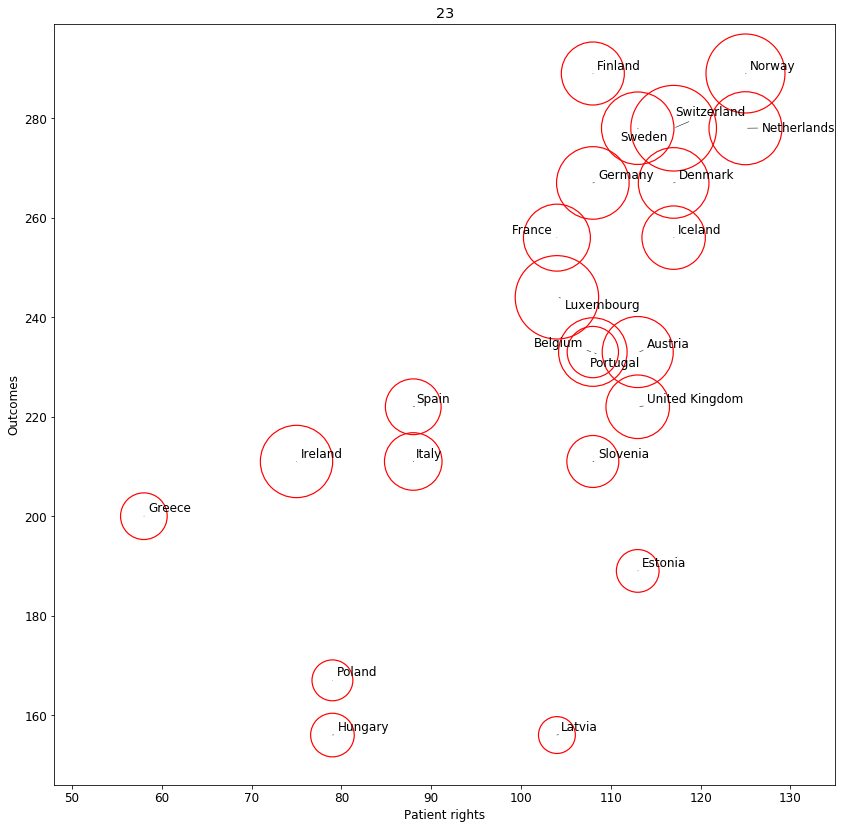

In [40]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from adjustText import adjust_text

def plot_df3(adjust=True):
    mpl.rcParams['font.size'] = 12.0
    plt.figure(figsize = (14, 14))
    plt.scatter(df3.Patientrights, df3.Outcomes, facecolors='none', edgecolors='red', linewidth=1.2, s=1*df3.Avg)
    texts = []
    plt.title('Relation between different health parameters')
    plt.xlabel('Patient rights')
    plt.ylabel('Outcomes')
    plt.xlim(xmin, xmax)
    plt.ylim(ymin, ymax)

    for x, y, s in zip(df3['Patientrights'], df3['Outcomes'], df3['Country']):
        texts.append(plt.text(x, y, s, size=12))
    if adjust:
        plt.title(str(adjust_text(texts, arrowprops=dict(arrowstyle="-", color='black', lw=0.5))
))

_ = plot_df3()
plt.show()

The visualization suggests a relation between patient rights and outcomes. The diameter of the circles displays expenditure. The higher expenditure countries have better patient rights and outcomes (mostly in the right top corner).

## **Summary**

The current blog showed how webtables can be scraped by using Python.
A certain amount of preprocessing is necessary before these data can be visualized.
Note that the world of webscraping is dynamic. The used websites and tables may be updated and therefore may require regular updates of Python code. 

Any questions or comments? 

Please feel free to contact me : 

Ruthger Righart

E: rrighart@googlemail.com

W: https://www.rrighart.com
___


## **References**

[1]. Data is the new oil. https://www.changethislimited.co.uk/2017/01/data-is-the-new-oil/

[2]. Data on internet. https://www.livescience.com/54094-how-big-is-the-internet.html

[3]. Beautiful Soup. https://www.crummy.com/software/BeautifulSoup/bs4/

[4]. Healthcare Europe. https://en.wikipedia.org/wiki/Healthcare_in_Europe

[5]. Visualizing European healthcare using Tableau. https://rrighart.github.io/HE-Tableau/

[6]. Scraping tables. https://stackoverflow.com/questions/17196018/extracting-table-contents-from-html-with-python-and-beautifulsoup

[7]. Health expenditure. https://en.wikipedia.org/wiki/List_of_countries_by_total_health_expenditure_per_capita

[8]. Hidden characters. https://stackoverflow.com/questions/31341351/how-can-i-identify-invisible-characters-in-python-strings

[9]. Adjust text package. https://github.com/Phlya/adjustText/blob/master/examples/Examples.ipynb

___


(c) 2018 . https://www.rrighart.com | https://rrighart.github.io